In [1]:
# 数据路径
# 如果是手动下载数据集，4个压缩文件放到'./mnist/raw/'中。
DATA_PATH = './fashion_mnist/'
# 如果数据集不存在是否下载数据集
DOWNLOAD_DATASET = True
# 批量大小
BATCH_SIZE = 100
# 设置，如果GPU可用，是否使用GPU
USEGPU = True
# GPU设备号
GPUNUM = 'cuda:0'
# GPUNUM = 'cuda:1'

In [2]:
# 用于构建神经网络和相应数据处理
import torch
import torch.utils.data
import torch.nn as nn
import torchvision
# 用于支持其他模块以及非torch的矩阵操作
import numpy as np
# 用于显示图像
import matplotlib.pyplot as plt

In [3]:
# 确定正在使用的运算设备
if USEGPU:
    device = torch.device(GPUNUM if torch.cuda.is_available() else "cpu")
else:
    device = 'cpu'

print('using',device)

using cuda:0


In [4]:
# 读取数据集
# 构造数据转换器
# dataset_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)),
#                                                    torchvision.transforms.ToTensor()])
# dataset_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((50,50)),
#                                                    torchvision.transforms.ToTensor()])
dataset_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((40,40)),
                                                    torchvision.transforms.ToTensor()])

# 分别读取训练集和测试集
train_data = torchvision.datasets.FashionMNIST(root=DATA_PATH, train=True,download=DOWNLOAD_DATASET, 
                                        transform=dataset_transform)
test_data = torchvision.datasets.FashionMNIST(root=DATA_PATH, train=False,download=DOWNLOAD_DATASET, 
                                        transform=dataset_transform)
# 分别构造训练集和测试集的加载器
# 在这一步进行shuffle打乱样本顺序
# 其实加载器每遍历一次都要随机重排一次
DataLoader = torch.utils.data.DataLoader
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

labels:
[0 6 2 5 3 4 6 2 9 4 1 7 3 1 7 6 0 6 0 7 9 6 4 3 5 7 3 3 5 3 1 3 6 7 5 1 4
 0 6 2 1 7 1 5 9 3 5 0 2 3 4 2 3 1 4 3 7 4 0 9 8 4 2 4 2 5 4 3 6 3 6 0 2 5
 3 0 3 6 2 8 8 0 3 6 6 3 0 4 8 1 0 7 7 2 2 4 2 9 5 2]
images:


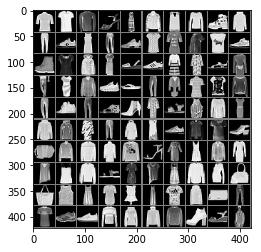

In [5]:
# 展示部分数据
# num控制显示多少个批次的图片。
def ViewDataset(datasetLoader, num):
    for i,data in enumerate(datasetLoader):
        if i<num:
            img, label =data
            tempimg = torchvision.utils.make_grid(img, pad_value=0.5, nrow=10)
            print('labels:')
            print(label.numpy())
            print('images:')
            # 设定要显示的内容
            plt.imshow(np.transpose(tempimg.numpy(),(1, 2, 0)))
            # 执行show函数就显示
            plt.show()
        else:
            break

ViewDataset(train_loader, 1)

In [6]:
# 定义网络
import torch.nn as nn
import torch.nn.functional as F

# 卷积之后，全连接层输入向量的长度。
# 由卷积结果的通道数乘以卷积结果的长再乘以卷积结果的宽得到。
# 这里没有用sigmoid函数，而是使用了softmax层
FC_SIZE = 512
class ClassificationMNIST(nn.Module):
    def __init__(self):
        super(ClassificationMNIST,self).__init__()
        self.preconv = nn.Conv2d(1,3,1,1)
        # 仅仅使用特征层
        self.vgg = torchvision.models.vgg16_bn(pretrained=True).features
        self.fc = nn.Sequential(nn.Linear(FC_SIZE, 10), nn.Softmax(dim=1))
        
    def forward(self, x):
        x = self.preconv(x)
        x = self.vgg(x)
        x = x.view(-1,FC_SIZE)
        #output = torch.sigmoid(x)
        output = self.fc(x)
        return output
    
# 原本的vgg中分类部分有三层全连接以及dropout。另外由于图像大小不一样，所以没法直接用（我又不想把图片放大太多，占内存）。
# 所以这里只用了vgg的特征提取层面。分类仅仅用一层全连接。

由于参数随机初始化等问题。可能一两次跑出来的结果并不理想。试试创建一个新实例重新训练。

In [7]:
# 初始化网络，及相关函数
cnn=ClassificationMNIST().to(device)
EPOCH = 10
# 学习率是个超参数，这东西是实验出来的
LR = 0.001
#LR = 0.01

# 定义损失函数和优化器
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_func = torch.nn.CrossEntropyLoss(size_average=False)

/home/wangqi/miniconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [8]:
# 进行训练
# 为了记录训练时间，使用datetime库
import datetime
if str(device) == 'cpu':
    pass
else:
    torch.cuda.synchronize()
starttime=datetime.datetime.now()
# 训练
for epoch in range(EPOCH):
    for i,data in enumerate(train_loader):
        # 获取数据并把训练用数据转移到GPU上
        b_x,b_y = data
        b_x = b_x.to(device)
        b_y = b_y.to(device)
        #print(b_x.size())
        # 前馈和计算损失
        output = cnn(b_x)
        loss = loss_func(output, b_y)
        # 反馈
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i% 500 == 0:
            for j,testdata in enumerate(test_loader):
                tx,ty =testdata
                tx = tx.to(device)
                ty = ty.to(device)
                test_output = cnn(tx)
                pred_y = torch.max(test_output, 1)[1].data.squeeze()  # move the computation in GPU
                accuracy = torch.sum(pred_y == ty).type(torch.FloatTensor) / ty.size(0)
                print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.cpu().numpy(), '| test accuracy: %.2f' % accuracy)
                break
                pass # 防止提示语法错误写了个pass。其实没有什么语法错误。可能是语法检查器的问题。

                
if str(device) == 'cpu':
    pass
else:
    torch.cuda.synchronize()
endtime=datetime.datetime.now()
print('Train time:',(endtime-starttime).seconds,'seconds')

Epoch:  0 | train loss: 230.1120 | test accuracy: 0.38
Epoch:  0 | train loss: 165.2292 | test accuracy: 0.85
Epoch:  1 | train loss: 159.2973 | test accuracy: 0.88
Epoch:  1 | train loss: 152.9880 | test accuracy: 0.90
Epoch:  2 | train loss: 160.5827 | test accuracy: 0.83
Epoch:  2 | train loss: 156.7430 | test accuracy: 0.89
Epoch:  3 | train loss: 162.0023 | test accuracy: 0.81
Epoch:  3 | train loss: 156.2373 | test accuracy: 0.90
Epoch:  4 | train loss: 155.9142 | test accuracy: 0.90
Epoch:  4 | train loss: 153.2398 | test accuracy: 0.87
Epoch:  5 | train loss: 157.9893 | test accuracy: 0.93
Epoch:  5 | train loss: 154.7263 | test accuracy: 0.87
Epoch:  6 | train loss: 156.8086 | test accuracy: 0.83
Epoch:  6 | train loss: 156.7835 | test accuracy: 0.87
Epoch:  7 | train loss: 156.8079 | test accuracy: 0.88
Epoch:  7 | train loss: 156.9444 | test accuracy: 0.90
Epoch:  8 | train loss: 154.0832 | test accuracy: 0.93
Epoch:  8 | train loss: 160.2383 | test accuracy: 0.93
Epoch:  9 

In [9]:
# 查看全部测试集
testLen=len(test_data)
tempSum=0
for i,testdata in enumerate(test_loader):
    img,label =testdata
    img,label = img.to(device), label.to(device)
    output = cnn(img)
    pre = torch.max(output, 1)[1].data.squeeze()
    #print('pre',pre)
    #print('label',label)
    tempSum = tempSum+(pre==label).sum()
print(float(tempSum.data)/testLen)

0.8935


In [10]:
cnn = cnn.to(torch.device('cpu'))

In [11]:
# 这里在把gpu上的模型转cpu的时候出了一点小问题。一直提示内存不足（实际上够，可能是是jupyter占用了或者bug）
# 但是保存一下重启jupyter，重新加载就可以
# torch.save(cnn, "/home/wangqi/mymodel")

In [12]:
# cnn = torch.load("/home/wangqi/mymodel",map_location=lambda storage, loc: storage)

In [13]:
# 对比真实图片查看分类效果
# beforeOutput 是后处理函数，训练的时候用softmax的结果。但是看的时候要数字标号。
def ViewNNOutput(datasetLoader, num, nn, beforeOutput):
    for i,data in enumerate(datasetLoader):
        if i<num:
            img, label =data
            print(img.size())
            tempimg = torchvision.utils.make_grid(img, pad_value=0.5, nrow=10)
            print('answers:')
            print(label.numpy())
            print('nn outputs:')
            print(beforeOutput(nn(img)))
            print('images:')
            # 设定要显示的内容
            plt.imshow(np.transpose(tempimg.numpy(),(1, 2, 0)))
            # 执行show函数就显示
            plt.show()
        else:
            break

torch.Size([100, 1, 40, 40])
answers:
[2 7 3 0 7 6 7 3 3 9 2 2 3 4 4 1 5 8 9 0 9 5 3 7 5 9 2 2 6 8 1 9 2 6 6 6 7
 8 0 0 2 0 8 9 5 1 9 8 4 9 7 4 1 3 6 5 9 0 2 1 7 2 8 6 9 4 0 0 6 3 8 0 7 8
 1 6 7 6 6 6 0 3 7 8 6 5 6 8 7 7 5 6 7 4 1 1 8 9 8 5]
nn outputs:
[2 7 3 0 7 6 7 4 3 9 2 2 3 4 4 1 5 8 9 0 9 5 3 7 5 9 2 2 6 8 1 9 2 6 6 6 7
 8 6 6 2 0 8 9 5 1 9 8 4 9 7 4 1 3 2 5 7 6 2 1 7 2 8 6 9 4 0 0 6 3 8 0 7 8
 1 6 7 6 0 6 0 1 7 8 6 5 6 8 7 7 9 4 7 4 1 1 8 9 8 5]
images:


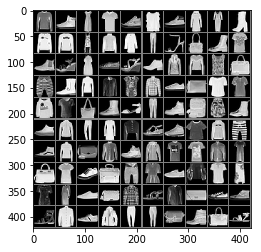

In [14]:
ViewNNOutput(test_loader, 1, cnn, lambda x: torch.max(x, 1)[1].numpy())

训练一个神经网络分类MNIST数据集中图片的任务到此算是告一段落了。

接下来我想顺便总结一点可视化的问题。神经网络，尤其是用于处理图像的神经网络。一些参数或者中间结构都可以当作图片来显示。把抽象的数据转化成直观图像，更方便对神经网络的理解和分析。也更能让人觉得你的工作量是有意义的。

首先是卷积核的可视化。卷积核本身是一个n$\times$m的矩阵。直接把它当作一个图片显示即可。现在主要的问题是如何把神经网络中的参数拿出来。在Pytorch框架中，每个神经网络实例都有一个`parameters`属性。这个属性中包含了所哟的参数。

In [15]:
# 看一下刚刚训练好的模型实例的参数
#cnn.parameters

In [16]:
# parameters是一个可以调用的方法。调用它之后会返回一个可迭代对象。
# for param in cnn.parameters():
#     # 每个data都是一个torch矩阵。这里为了方便查看只输出他们的维度。
#     print(param.size())

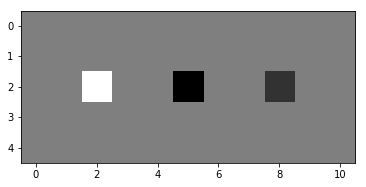

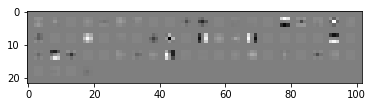

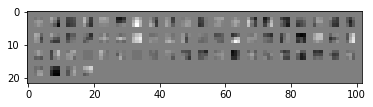

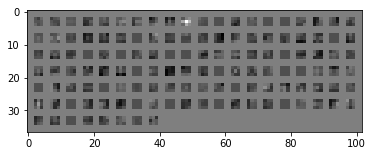

In [17]:
for j,param in enumerate(cnn.parameters()):
    # 只要4维度的卷积核参数
    if len(param.size()) == 4:
        # 遍历所有通道，都按照灰度图输出
        for i in range(param.size()[1]):
            #print(param)
            # 为了显示负的像素我们使用maxmin缩放
            tempdata = param.data[:, i:i+1]
            tempdata = (tempdata-tempdata.min())/(tempdata.max()-tempdata.min())
            tempimg = torchvision.utils.make_grid(tempdata, pad_value=0.5, nrow=20)
            plt.imshow(np.transpose(tempimg.to(torch.device('cpu')).data.numpy(),(1, 2, 0)))
            plt.show()
            # 图太多，不全部显示
            break
    # 只看几层，剩下的不用看
    if j>10:
        break

In [18]:
# 要查看中间结果更方便。神经网络模型实例中每一层都可以作为一个成员单独访问。
# 在我们的ClassificationMNIST模型中。使用了两个系列的层。分别命名为conv和fc。
#print(cnn.vgg)
#print(cnn.fc)

# 每个系列都是由若干层组成。使用访问数组的方式访问其中的某一层。数组切片在这里同样适用。
#print(cnn.conv[2])
#print(cnn.conv[2:5])

# 每个层或者序列都可以当作函数使用
# 为了防止输出太长，两个结果都只输出size.
#print(cnn.conv(torch.randn(1,1,28,28)).size())
#print(cnn.conv[:5](torch.randn(1,1,28,28)).size())

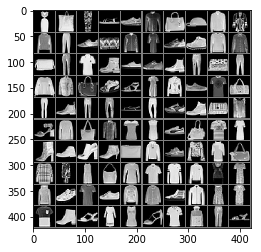

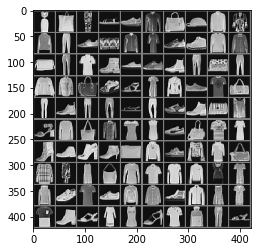

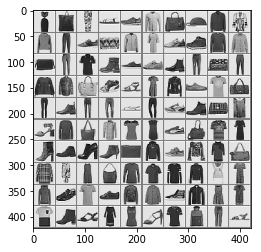

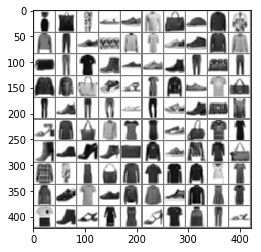

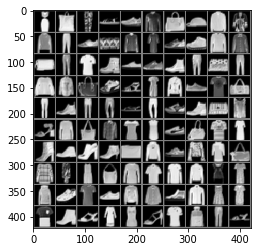

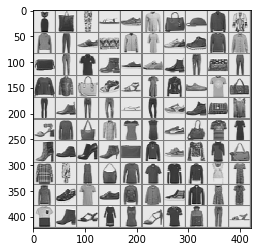

In [19]:
# 所以要查看某一步骤的中间结果，直接索引出来这一层。然后对某张图片使用就可以了。
level = nn.Sequential(cnn.preconv,cnn.vgg[:2])
for i,data in enumerate(test_loader):
    img,label = data
    output = level(img)
    # 输出原图
    tempimg = torchvision.utils.make_grid(img, pad_value=0.5, nrow=10)
    plt.imshow(np.transpose(tempimg.data.numpy(),(1, 2, 0)))
    plt.show()
    # 由于中间结果有多个通道，我们一个通道一个通道看。
    for j in range(output.size()[1]):
        # 输出卷积结果
        # maxmin缩放，使得能看见负数值
        tempdata = output[:, j:j+1]
        tempdata = (tempdata-tempdata.min())/(tempdata.max()-tempdata.min())
        tempimg = torchvision.utils.make_grid(tempdata, pad_value=0.5, nrow=10)
        plt.imshow(np.transpose(tempimg.data.numpy(),(1, 2, 0)))
        plt.show()
        # 看几张就行了
        if j >3:
            break
    # 仅仅查看第一个批次的图片，后边的就不看了
    break


In [20]:
# 测试一下卷积卷到没有怎么办
level = nn.Sequential(cnn.preconv,cnn.vgg)
print(level(torch.randn(1,1,50,50)).size())
print(level(torch.randn(1,1,39,40)).size())
# 稍微小一点没有事，但是小到28*28会出问题。
# 之所以选50，是直接试了一下，不报错就行。

torch.Size([1, 512, 1, 1])
torch.Size([1, 512, 1, 1])


In [21]:
# 卷积还是有一定的对尺寸容错能力的（大概是差一两个像素不能卷就扔掉）
# 有时间具体落实一下这个究竟是怎么做到容错的。是不是多出几个像素的时候就舍弃。
# 但是不能差太多，把28*28的直接扔进VGG中是不行的
level = nn.Sequential(nn.Conv2d(1,4,3,3))
print(level(torch.randn(1,1,8,10)).size())
print(level(torch.randn(1,1,8,7)).size())
print(level(torch.randn(1,1,6,7)).size())
print(level(torch.randn(1,1,6,5)).size())
print(level(torch.randn(1,1,4,5)).size())
print(level(torch.randn(1,1,4,3)).size())
# 但是不能小于一个卷积核的大小
# print(level(torch.randn(1,1,3,2)).size())
# 据WK说是自动把不够卷积的部分进行了插值，而不是删除了多出来还不够卷积的部分。
# 但是看卷积前后的结果，很像是舍弃了。

torch.Size([1, 4, 2, 3])
torch.Size([1, 4, 2, 2])
torch.Size([1, 4, 2, 2])
torch.Size([1, 4, 2, 1])
torch.Size([1, 4, 1, 1])
torch.Size([1, 4, 1, 1])
